# Analyse results of param sweeping (version 2)  
I want to compare the consistency of H and P criteria in ranking probes.  
For each "layer-dim" combo (capacity of the probe), train it with the same learning procedure. Find the correlations between different measurement procedures.  
The learning procedure goes as following:  
1. For each experiment, train until convergence, then get the model state with lowest dev loss. Report test loss and acc as result.  
2. Sweep a series of learning rates. For each learning rate, run four seeds. Avg the results.  

In [2]:
import pandas as pd
import numpy as np
import sys, os, time
from tqdm import tqdm
import scipy
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from utils import timed_func, combine_df

long_df = combine_df("../src/archive/20200502_sweep/")
long_df.head()

,lm,lang,task,layer,dim,batch_size,init_lr*1e6,lr_anneal,max_grad_step,seed,devloss,testloss,acc
0,bertmulti,en,probe,0,10,32,100.0,0.5,-1,73,1.382249,1.416134,66.110984
1,bertmulti,en,probe,0,10,32,100.0,0.5,-1,421,1.315590,1.306115,68.600137
2,bertmulti,en,probe,0,10,32,100.0,0.5,-1,9973,1.157389,1.206659,68.097739
3,bertmulti,en,probe,0,10,32,100.0,0.5,-1,361091,1.390447,1.378814,65.760828
4,bertmulti,en,ctarget,0,10,32,100.0,0.5,-1,73,2.833213,2.833213,6.237780


In [5]:
@timed_func
def prepare_df_by_lang(lang="en", verbose=False):
    df_src = "../src/archive"
    folders = [
        "20200502_sweep",
        "20200508_en_fr_es_maxgradstep_1500",
        "20200508_en_fr_es_maxgradstep_3000",
        "20200508_en_fr_es_maxgradstep_6000",
        "20200512_en_fr_es_maxgradstep_12000",
        "20200512_en_fr_es_maxgradstep_24000",
        "20200515_wd_0.01", 
        "20200515_wd_0.10",
        "20200515_wd_1.00",
        "20200516_en_fr_es_maxgradstep_48000",
        "20200516_en_fr_es_maxgradstep_96000",
        "20200519_en_fr_es_maxgradstep_additional"
    ]
    dfs = []
    for fname in folders:
        df = combine_df(os.path.join(df_src, fname), verbose=verbose)
        dfs.append(df)
    df_long = pd.concat(dfs)
    df_by_lang = df_long[df_long.lang == lang]
    if verbose:
        print ("Combined df length is {}. {} in language {}".format(
            len(df_long), len(df_by_lang), lang))
    return df_by_lang

df_en = prepare_df_by_lang("en")
print(df_en.shape)
df_fr = prepare_df_by_lang("fr")
print(df_fr.shape)
df_es = prepare_df_by_lang("es")
print(df_es.shape)

prepare_df_by_lang done in 1.89 seconds.
(10335, 15)
prepare_df_by_lang done in 1.25 seconds.
(9106, 15)
prepare_df_by_lang done in 1.01 seconds.
(9174, 15)


In [1]:
def find_rows(df, row, task):
    return df[(df.lang==row.lang) & (df.layer==row.layer) & \
       (df.dim==row.dim) & (df["init_lr*1e6"]==row["init_lr*1e6"]) & \
       (df.batch_size==row.batch_size) & (df.lr_anneal==row.lr_anneal) & \
       (df.max_grad_step==row.max_grad_step) & (df.task==task)].mean()

def measure_correlation(df):
    """
    Version 2: For each {nlayer, ndim, lr, task} config: there are n_seed entries. Take the mean of them.
    """
    experiments = []
    
    for i, row in tqdm(df.iterrows(), total=len(df), file=sys.stdout):
        if row.task == "probe":
            probe_row = find_rows(df, row, task="probe")
            ctarget_row = find_rows(df, row, task="ctarget")
            crep_row = find_rows(df, row, task="crep")
            if (ctarget_row is not None) and (crep_row is not None):
                rmt_acc = probe_row.acc - ctarget_row.acc  # Hewitt criterion
                rmt_ent = -probe_row.testloss + ctarget_row.testloss
                rmr_acc = probe_row.acc - crep_row.acc
                rmr_ent = -probe_row.testloss + crep_row.testloss  # Pimentel criterion
            
                experiments.append({
                    "exp_id": i,
                    "rmt_acc": rmt_acc,
                    "rmt_ent": rmt_ent,
                    "rmr_acc": rmr_acc,
                    "rmr_ent": rmr_ent
                })
                
    print ("There are {} experiment sets".format(len(experiments)))
    L_rmt_acc = sorted(experiments, key=lambda item: item["rmt_acc"])  # Hewitt
    L_rmt_ent = sorted(experiments, key=lambda item: item["rmt_ent"])
    L_rmr_acc = sorted(experiments, key=lambda item: item["rmr_acc"])
    L_rmr_ent = sorted(experiments, key=lambda item: item["rmr_ent"])  # Pimentel
    
    ids_rmt_acc = [item["exp_id"] for item in L_rmt_acc]
    ids_hewitt = ids_rmt_acc
    ids_rmt_ent = [item["exp_id"] for item in L_rmt_ent]
    ids_rmr_acc = [item["exp_id"] for item in L_rmr_acc]
    ids_rmr_ent = [item["exp_id"] for item in L_rmr_ent]
    ids_pimentel = ids_rmr_ent
    
    print ("df has {} rows".format(len(df)))
    corr, p = spearmanr(ids_hewitt, ids_pimentel)
    print ("rmt_acc vs rmr_ent (Hewitt vs Pimentel) corr: {:.4f}, p={:.4f}".format(corr, p))
    
    corr, p = spearmanr(ids_rmt_acc, ids_rmt_ent)
    print ("rmt_acc (Hewitt) vs rmt_ent corr: {:.4f}, p={:.4f}".format(corr, p))
    
    corr, p = spearmanr(ids_rmr_acc, ids_rmr_ent)
    print ("rmr_acc vs rmr_ent (Pimentel) corr: {:.4f}, p={:.4f}".format(corr, p))
    
    fig = plt.figure()
    plt.scatter(ids_rmt_acc, ids_rmr_ent, label="Hewitt v Pimentel", s=2)
    plt.xlabel("Rank of experiments by Hewitt criterion")
    plt.ylabel("Rank of experiments by Pimentel criterion")
    plt.show()
#measure_correlation(combine_df("../src/archive/20200502_sweep"))

In [2]:
#measure_correlation(combine_df("../src/archive/20200503_en_fr_es"))

In [3]:
#measure_correlation(combine_df("../src/archive/20200508_en_fr_es_maxgradstep_1500"))

In [4]:
#measure_correlation(combine_df("../src/archive/20200508_en_fr_es_maxgradstep_3000"))

In [5]:
#measure_correlation(combine_df("../src/archive/20200508_en_fr_es_maxgradstep_6000"))

In [6]:
#measure_correlation(combine_df("../src/archive/20200512_en_fr_es_maxgradstep_12000"))

In [7]:
#measure_correlation(combine_df("../src/archive/20200512_en_fr_es_maxgradstep_24000"))

prepare_df_by_lang done in 0.84 seconds.
100%|██████████| 10335/10335 [02:07<00:00, 81.18it/s]
There are 3434 experiment sets
df has 10335 rows
rmt_acc vs rmr_ent (Hewitt vs Pimentel) corr: 0.1615, p=0.0000
rmt_acc (Hewitt) vs rmt_ent corr: 0.1334, p=0.0000
rmr_acc vs rmr_ent (Pimentel) corr: 0.1763, p=0.0000


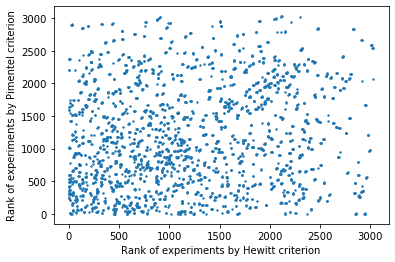

prepare_df_by_lang done in 0.80 seconds.
100%|██████████| 9106/9106 [01:53<00:00, 79.94it/s] 
There are 3036 experiment sets
df has 9106 rows
rmt_acc vs rmr_ent (Hewitt vs Pimentel) corr: 0.0906, p=0.0000
rmt_acc (Hewitt) vs rmt_ent corr: 0.0606, p=0.0008
rmr_acc vs rmr_ent (Pimentel) corr: 0.1295, p=0.0000


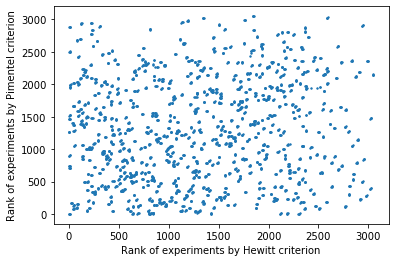

prepare_df_by_lang done in 0.95 seconds.
100%|██████████| 9174/9174 [02:02<00:00, 74.94it/s]
There are 3058 experiment sets
df has 9174 rows
rmt_acc vs rmr_ent (Hewitt vs Pimentel) corr: 0.1360, p=0.0000
rmt_acc (Hewitt) vs rmt_ent corr: 0.0560, p=0.0020
rmr_acc vs rmr_ent (Pimentel) corr: 0.1254, p=0.0000


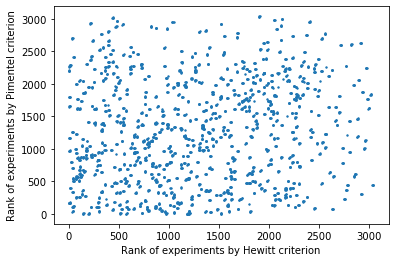

In [6]:
measure_correlation(prepare_df_by_lang("en"))
measure_correlation(prepare_df_by_lang("fr"))
measure_correlation(prepare_df_by_lang("es"))